In [110]:
import numpy as np 
import matplotlib.pyplot as plt 
from qiskit.quantum_info import SparsePauliOp, Pauli 
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import datetime

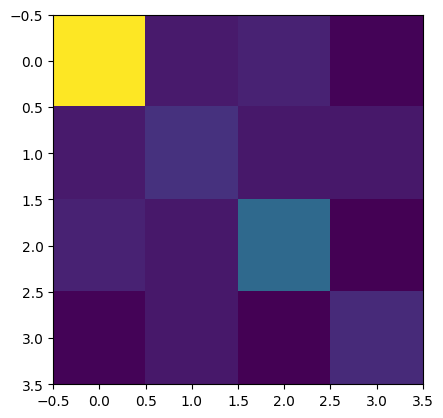

In [111]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [112]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
                expected_returns=mu, 
                covariances=sigma, 
                risk_factor=q, 
                budget=budget
                )

qp = portfolio.to_quadratic_program()
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

result.x 

array([1., 0., 0., 1.])

In [113]:
def asset_operator( qubit ):
    z = np.zeros(num_assets)
    x = np.zeros(num_assets)
    z[qubit] = 1
    Op = SparsePauliOp( [ Pauli(num_assets*'I'),Pauli((z,x))], [0.5,-0.5] ) 
    return Op 

H_fun = SparsePauliOp( num_assets*'I', 0 )
for i in range(num_assets):
    Op1 = asset_operator( i )
    H_fun = H_fun - mu[i]*Op1
    for j in range(num_assets):
        Op2 = asset_operator( j )
        H_fun = H_fun + q*sigma[i,j]*Op1@Op2 

H_con = SparsePauliOp( num_assets*'I', -budget )
for i in range(num_assets):
    Op1 = asset_operator( i )
    H_con = H_con + Op1 
H_con = H_con @ H_con 

H = H_fun + H_con 
H = H.simplify()
H 

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[ 9.93020582e-01+0.j,  6.98131079e-03+0.j, -4.97829400e-04+0.j,
  5.00018351e-01+0.j,  4.66451258e-05+0.j,  5.00032150e-01+0.j,
  4.30346516e-04+0.j,  4.99975035e-01+0.j,  5.00013261e-01+0.j,
  5.00011120e-01+0.j,  4.99969028e-01+0.j])

In [114]:
np.linalg.eigh( H.to_matrix() )[0]

array([-1.48846131e-02, -1.40072600e-02, -1.30300946e-02, -1.01711513e-03,
        1.83617578e-04,  8.41070055e-04,  9.84997932e-01,  9.85986308e-01,
        9.86143466e-01,  9.87029380e-01,  9.99228940e-01,  9.99877832e-01,
        9.99990605e-01,  1.00091020e+00,  3.98607905e+00,  4.00000000e+00])

In [115]:
results = NumPyMinimumEigensolver().compute_minimum_eigenvalue( H )
results.eigenvalue

np.complex128(-0.01488461311339262+0j)

In [116]:
results.eigenstate.to_dict()

{np.str_('1001'): np.complex128(1+0j)}

In [117]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit import QuantumCircuit 

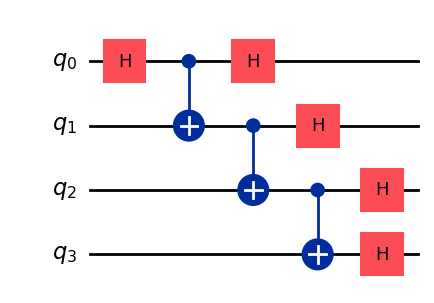

In [118]:
initial_state = QuantumCircuit(num_assets)
initial_state.h(0)
for j in range(num_assets-1):
    initial_state.cx(j,j+1)
initial_state.h(range(num_assets))
initial_state.draw('mpl') 

In [119]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

reps = 5
cobyla = COBYLA()
cobyla.set_options(maxiter=500)

data = []
def callback(*vars):
    data.append( vars )

qaoa_solver = QAOA( Sampler(), optimizer=cobyla, 
                    reps=reps, 
                    # initial_state=initial_state, 
                    # initial_point=np.zeros(2*reps),
                    callback = callback
                    )

# from qiskit_algorithms import SamplingVQE
# from qiskit.circuit.library import TwoLocal

# ry = TwoLocal(num_assets, "ry", "cz", reps=4, entanglement="full", 
#                 # initial_state=initial_state
#                 )
# svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
# results_vqe = svqe_mes.compute_minimum_eigenvalue( H )
# plot_histogram( results_vqe.eigenstate )

In [120]:
results_qaoa = qaoa_solver.compute_minimum_eigenvalue( H )
results_qaoa.best_measurement 

{'state': 9,
 'bitstring': '1001',
 'value': np.complex128(-0.014884613113392675+0j),
 'probability': 0.1826171875}

c:\Users\lucia\miniconda3\envs\ECC2025\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\lucia\miniconda3\envs\ECC2025\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


np.complex128(0.021613095947104925+0j)

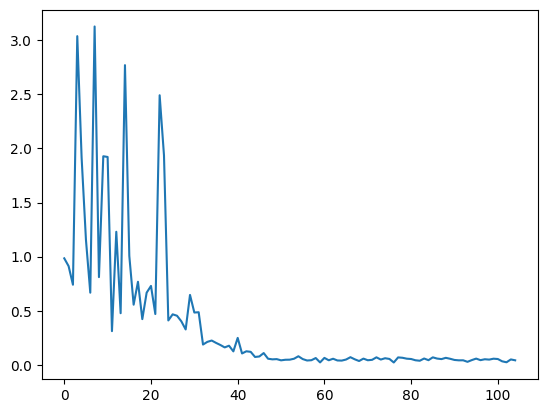

In [121]:
plt.plot( [ k[2] for k in data ] )
np.min( [ k[2] for k in data ]  )

In [122]:
results_qaoa.__dict__ 

{'_eigenvalue': np.float64(0.04166513423670921),
 '_eigenstate': {1: 0.0068359375, 10: 0.1669921875, 9: 0.1484375, 6: 0.1728515625, 14: 0.0068359375, 5: 0.1513671875, 3: 0.1416015625, 12: 0.173828125, 15: 0.00390625, 2: 0.0107421875, 8: 0.0068359375, 13: 0.001953125, 11: 0.001953125, 7: 0.0029296875, 4: 0.0029296875},
 '_aux_operator_values': None,
 '_best_measurement': {'state': 9,
  'bitstring': '1001',
  'value': np.complex128(-0.014884613113392675+0j),
  'probability': 0.1826171875},
 '_optimizer_evals': None,
 '_optimizer_time': 1.145805835723877,
 '_optimal_value': np.float64(0.04166513423670921),
 '_optimal_point': array([ 7.11767742, -0.36807327,  4.74040708, -3.30862314, -2.41449792,
        -3.79836015, -3.85726405, -2.26629153,  5.52809886, -3.2191135 ]),
 '_optimal_parameters': {ParameterVectorElement(β[0]): np.float64(7.117677420293338),
  ParameterVectorElement(β[1]): np.float64(-0.3680732734383164),
  ParameterVectorElement(β[2]): np.float64(4.740407079029496),
  Paramet

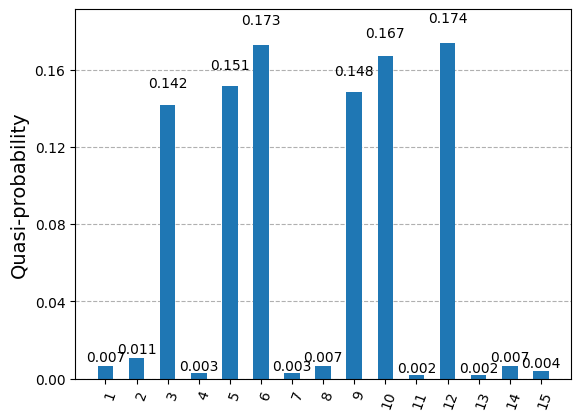

In [123]:
from qiskit.visualization import plot_histogram
plot_histogram( results_qaoa.eigenstate )